### Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
import random

### get_seed

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

torch.cuda.manual_seed(random_seed)

### get_array

In [3]:
train_array = np.load('/workspace/대회/npy_files/all_array_.npy')

inf_array = np.load('/workspace/대회/npy_files/inf_array_.npy')

train_array_T = np.transpose(train_array,(0,2,1))
inf_array_T = np.transpose(inf_array,(0,2,1))

print(train_array_T.shape)
print(inf_array_T.shape)

(58631, 10, 2000)
(8744, 10, 2000)


### get_loader

In [4]:
BATCH_SIZE =  128

train_loader = torch.utils.data.DataLoader(train_array_T[:300,:3,:], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
inf_loader = torch.utils.data.DataLoader(inf_array_T[:,:3,:], batch_size = BATCH_SIZE, shuffle=False, num_workers=0)

### Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self,  in_channel, out_channel_lst, kernel_size, stride):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel_lst = out_channel_lst 
        self.kernel_size = kernel_size 
        self.stride = stride 


        self.conv1d_1 = nn.Conv1d(self.in_channel, self.out_channel_lst[0], self.kernel_size, self.stride)

        self.conv1d_2 = nn.Conv1d(self.out_channel_lst[0], self.out_channel_lst[1], self.kernel_size, self.stride)
        
        self.bn1 = nn.BatchNorm1d(self.out_channel_lst[0])
        self.bn2 = nn.BatchNorm1d(self.out_channel_lst[1])
        
        self.after_1 = int((2000-self.kernel_size)//self.stride+1)
        self.after_2 = int((self.after_1-self.kernel_size)//self.stride+1)
        
        self.fc1 = nn.Linear(self.after_2,self.after_2//2)
        self.fc2 = nn.Linear(self.after_2//2,self.after_2//4)
        

    def forward(self, x):
#         print('input_shape',x.shape)
        
        w_1 = self.bn1(self.conv1d_1(x))
#         print('w_1',w_1.shape)
        
        w_2 = self.bn2(self.conv1d_2(w_1))
#         print('w_2',w_2.shape)
        
        w_3 = w_2.view(w_2.shape[0],-1)
#         print('w_3', w_3.shape)
        
        l_1 = self.fc1(w_3)
#         print('l_1',l_1.shape)

        l_2 = self.fc2(l_1)
#         print('l_2',l_2.shape)


        return l_2

### Decoder

In [6]:
class Decoder(nn.Module):
    def __init__(self,  in_channel, out_channel_lst, kernel_size, stride):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel_lst = out_channel_lst 
        self.kernel_size = kernel_size 
        self.stride = stride


        self.conv1d_1 = nn.ConvTranspose1d( self.out_channel_lst[1], self.out_channel_lst[0], self.kernel_size, self.stride)
        self.conv1d_2 = nn.ConvTranspose1d(self.out_channel_lst[0], self.in_channel, self.kernel_size, self.stride)
        
        self.bn1 = nn.BatchNorm1d(self.out_channel_lst[0])
        self.bn2 = nn.BatchNorm1d(self.in_channel)

        self.after_1 = int((2000-self.kernel_size)//self.stride+1)
        self.after_2 = int((self.after_1-self.kernel_size)//self.stride+1)
        
        self.fc1 = nn.Linear(self.after_2//4,self.after_2//2)
        self.fc2 = nn.Linear(self.after_2//2,self.after_2)

    def forward(self, z):
        
        l_1 = self.fc1(z)
#         print('l_1',l_1.shape)
        
        l_2 = self.fc2(l_1)
#         print('l_2',l_2.shape)
        
        l_ = l_2.view(l_1.shape[0],1,-1)
#         print('l_',l_.shape)
        
        z_1 = self.bn1(self.conv1d_1(l_))
#         print('z_1', z_1.shape)
        
        z_2 = self.bn2(self.conv1d_2(z_1))
#         print('z_2', z_2.shape)
        


        return z_2

### Model_

In [7]:
class UsadModel_CONV_AE(nn.Module):
    def __init__(self,  in_channel, out_channel_lst, kernel_size, stride):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel_lst = out_channel_lst 
        self.kernel_size = kernel_size 
        self.stride = stride
        
        self.encoder = Encoder(self.in_channel, self.out_channel_lst, self.kernel_size, self.stride)
        self.decoder = Decoder(self.in_channel, self.out_channel_lst, self.kernel_size, self.stride)
        
    def forward(self, x):
        out_1 = self.encoder(x)        
        
        out_2 = self.decoder(out_1)
        
        mse_ = (x - out_2)**2
        
        return out_1, out_2, mse_
    
device = 'cuda'
model_conv_ae = UsadModel_CONV_AE(3,[2,1],500,1)
optimizer = torch.optim.Adam(list(model_conv_ae.encoder.parameters())+list(model_conv_ae.decoder.parameters()))
model_conv_ae.to(device)

UsadModel_CONV_AE(
  (encoder): Encoder(
    (conv1d_1): Conv1d(3, 2, kernel_size=(500,), stride=(1,))
    (conv1d_2): Conv1d(2, 1, kernel_size=(500,), stride=(1,))
    (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=1002, out_features=501, bias=True)
    (fc2): Linear(in_features=501, out_features=250, bias=True)
  )
  (decoder): Decoder(
    (conv1d_1): ConvTranspose1d(1, 2, kernel_size=(500,), stride=(1,))
    (conv1d_2): ConvTranspose1d(2, 3, kernel_size=(500,), stride=(1,))
    (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=250, out_features=501, bias=True)
    (fc2): Linear(in_features=501, out_features=1002, bias=True)
  )
)

### train_function

In [8]:
def train(model, train_loader, epoch, optimizer, device='cuda'):

    model.train()

    losses_train = []
    for batch in train_loader:
        out_1, out_2, mse_ = model(batch.type(torch.FloatTensor).to(device))
        loss = torch.mean(mse_)
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        losses_train.append(loss.item())

    losses_train = np.mean(losses_train)


    return losses_train

In [9]:
epochs = 5
for epoch in range(epochs):
    train_loss_ = train(model_conv_ae, train_loader, epochs, optimizer)
    print(f'epoch - {epoch}  train_loss_1 - {train_loss_}')

epoch - 0  train_loss_1 - 25.54424508412679
epoch - 1  train_loss_1 - 25.26287015279134
epoch - 2  train_loss_1 - 23.040531158447266
epoch - 3  train_loss_1 - 21.646508534749348
epoch - 4  train_loss_1 - 21.36795457204183


### testing

In [10]:
def testing(model, test_loader, device = 'cuda'):
    latent_space_ = np.empty((0, 250))
    mse_arr = np.empty((0,3,2000))
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            out_1, out_2, mse_ = model(batch.type(torch.FloatTensor).to(device))

            out_1 = out_1.cpu()
            out_2 = out_2.cpu()
            mse_ = mse_.cpu()
            
            latent_space_ = np.concatenate([latent_space_,out_1])
            mse_arr = np.concatenate([mse_arr,mse_])

        return latent_space_, mse_arr

In [11]:
latent_space_inf, mse_arr_inf = testing(model_conv_ae,inf_loader)
latent_space_all , mse_arr_all = testing(model_conv_ae, train_loader)

In [12]:
mse_arr_inf

array([[[4.98795301e-01, 2.26620674e+00, 5.12942314e+00, ...,
         2.45497391e-01, 3.08168661e-02, 1.80538312e-01],
        [5.89665222e+00, 3.63694072e+00, 2.04244423e+00, ...,
         1.14875298e+01, 1.12196150e+01, 8.00150776e+00],
        [7.03942680e+00, 8.14668274e+00, 9.57326412e+00, ...,
         5.81921148e+00, 6.83492470e+00, 7.25742531e+00]],

       [[1.25406742e+01, 8.43356228e+00, 8.21776772e+00, ...,
         2.10173283e+01, 1.43201275e+01, 1.34267588e+01],
        [8.99823606e-02, 6.12777352e-01, 1.58180535e+00, ...,
         8.11728001e-01, 6.74356371e-02, 9.62765455e-01],
        [7.72648430e+00, 9.34957504e+00, 1.25290794e+01, ...,
         1.03733482e+01, 1.22309647e+01, 1.61524372e+01]],

       [[9.66150379e+00, 6.48551941e+00, 3.33202457e+00, ...,
         1.06809301e+01, 1.12098274e+01, 9.65752316e+00],
        [6.84705114e+00, 7.06057405e+00, 8.15483570e+00, ...,
         3.90518880e+00, 5.83870316e+00, 6.43444633e+00],
        [8.25187005e-03, 3.47290754e

### Clustering_by_latent_space

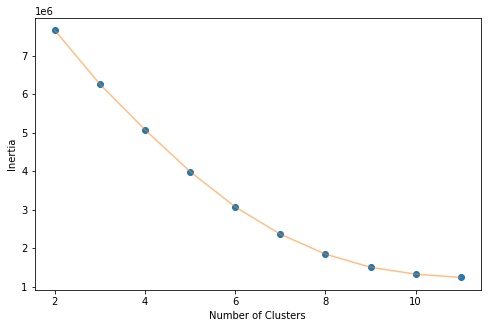

In [13]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], latent_space_all)

### get_dictionary_from_clustering

In [14]:
def get_index_label(latent_arr, n_clu):
    k_model = KMeans(n_clusters = n_clu, n_init=25, max_iter = 600, random_state=42)
    k_model.fit(latent_arr)
    label_ = k_model.labels_
    
    dic = {}
    for i in range(n_clu):
        dic[i] = np.where(label_==i)[0]
    
    return dic

In [15]:
label_dict = get_index_label(latent_space_all, 6)

### check_loss

In [17]:
def get_sum_arr(arr):
    sum_arr = arr.sum(axis=2)
    sum_arr_2 = sum_arr.sum(axis=1)
    return sum_arr_2.reshape(-1,1)

def get_mean_arr(arr):
    mean_arr = get_sum_arr(arr)/6000
    return mean_arr

In [18]:
mean_arr_inf = get_mean_arr(mse_arr_inf)
sum_arr_inf = get_sum_arr(mse_arr_inf)

mean_arr_all = get_mean_arr(mse_arr_all)
sum_arr_all = get_sum_arr(mse_arr_all)

In [19]:
def get_scaling(all_arr, inf_arr):
    scaler = MinMaxScaler()
    scaler.fit(all_arr)
    print(scaler.n_samples_seen_, scaler.data_min_, scaler.data_max_, scaler.feature_range)

    fi = scaler.transform(inf_arr)
    fi = np.squeeze(fi)
    


    return fi

### check_loss_group_by_scatter

(300, 1)

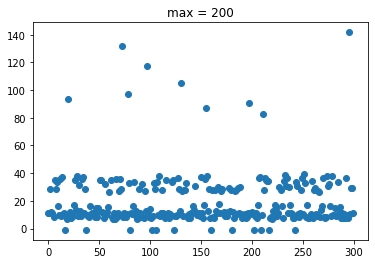

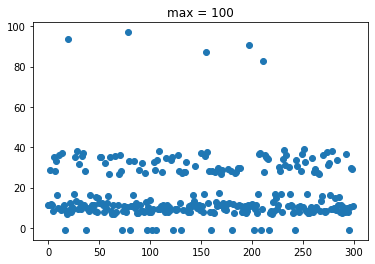

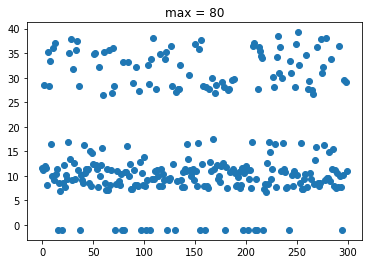

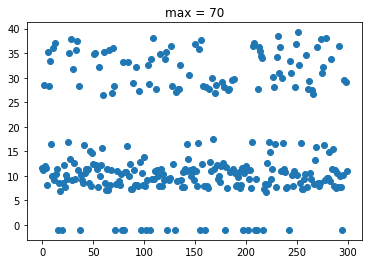

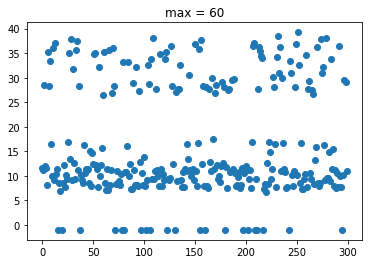

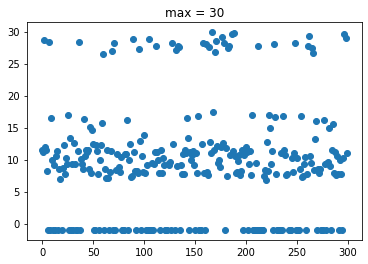

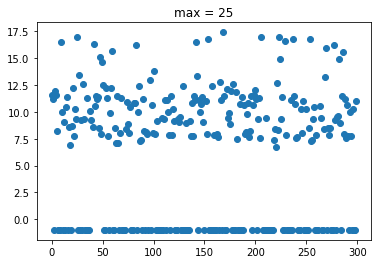

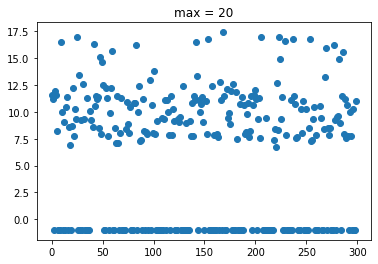

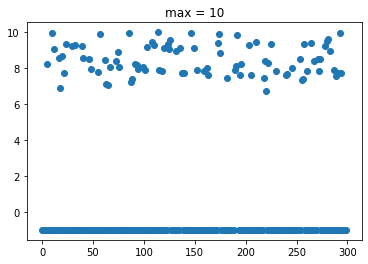

In [25]:
mean_arr_all_ = np.squeeze(mean_arr_all)
for i in [200,100, 80, 70, 60, 30, 25, 20, 10]:
    mean_arr_all_2 = np.where(mean_arr_all_<=i,mean_arr_all_,-1)
    plt.plot([i for i in range(300)],mean_arr_all_2,
         linestyle='none',
         marker = 'o')
    plt.title(f'max = {i}')
    plt.show()